# Connect to Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/deeplearning/projects/en-text-sum-fine-tuned-bart/

Mounted at /content/drive
/content/drive/MyDrive/deeplearning/projects/en-text-sum-fine-tuned-bart


# Load dataset

In [2]:
import pandas as pd

df = pd.read_csv('dataset/wikihow_cleaned.csv')

print(f'Shape of dataset: {df.shape}')
print('Information of dataset:')
df.info()

Shape of dataset: (186101, 2)
Information of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186101 entries, 0 to 186100
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      186101 non-null  object
 1   headline  186101 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


# Calculate sentence length of each features

In [3]:
def compute_length(text: str) -> int:
  return len(str(text).split(' '))

df.loc[:, 'text_length'] = df['text'].apply(compute_length)
df.loc[:, 'headline_length'] = df['headline'].apply(compute_length)

print('Current information of dataset:')
df.info()
print('Statistics of headline_length and text_length:')
df[['headline_length', 'text_length']].describe()

Current information of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186101 entries, 0 to 186100
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             186101 non-null  object
 1   headline         186101 non-null  object
 2   text_length      186101 non-null  int64 
 3   headline_length  186101 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.7+ MB
Statistics of headline_length and text_length:


,headline_length,text_length
count,186101.000000,186101.000000
mean,60.787148,541.198661
std,53.427598,531.611840
min,2.000000,6.000000
25%,27.000000,217.000000
50%,44.000000,374.000000
75%,78.000000,645.000000
max,4083.000000,13319.000000


# Plot sentence length in original dataset

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use('default')

statistics_dir = 'statistics'
Path(statistics_dir).mkdir(parents=True, exist_ok=True)

def plot_histogram(
    df: pd.DataFrame,
    column: str,
    title: str,
    **kwargs
):
    mean = df[column].mean()
    max = df[column].max()

    plt.figure(figsize=(10, 5))
    ax = sns.histplot(df[column], bins=100)

    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.axvline(x=mean, color='red', linestyle='--')
    plt.text(
      x=(mean / max),
      y=0.99,
      s=f'mean={mean:.2f}',
      color='red',
      ha='left',
      va='top',
      transform=ax.transAxes,
    )

    file_path = f"{statistics_dir}/{'_'.join(title.lower().split())}.png"
    plt.savefig(file_path, bbox_inches='tight')
    print(f'Saved to {file_path}')
    plt.show()

Saved to statistics/histogram_of_headline_length_in_cleaned_dataset.png


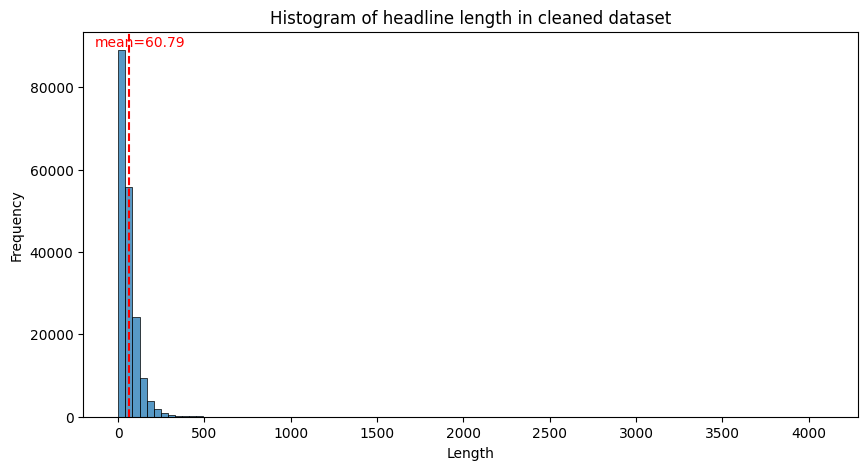

In [5]:
plot_histogram(
  df=df,
  column='headline_length',
  title='Histogram of headline length in cleaned dataset',
)

Saved to statistics/histogram_of_text_length_in_cleaned_dataset.png


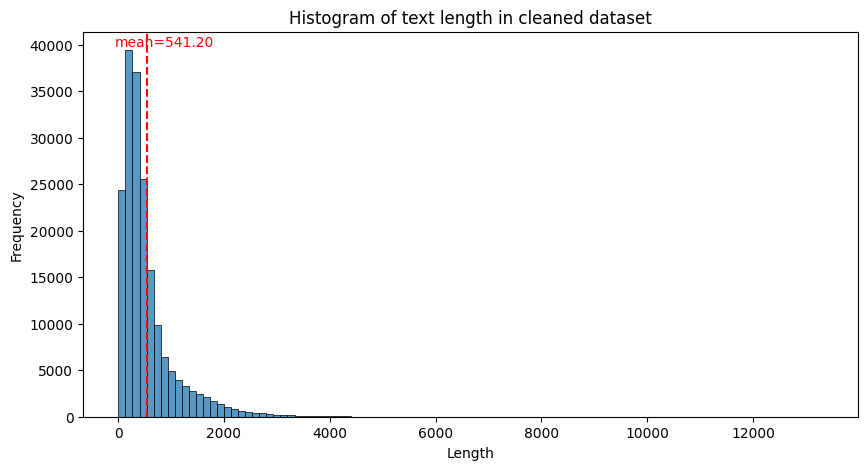

In [6]:
plot_histogram(
  df=df,
  column='text_length',
  title='Histogram of text length in cleaned dataset',
)

# Statistic sentence length of each features by percentile

In [7]:
import numpy as np

percentiles = [0.02, 0.05, 0.08, 0.1, 0.9, 0.95, 0.99]

stats = []

for p in percentiles:
  stat = {
      'percentile': round(p * 100, 2),
      'text_length': round(np.percentile(df['text_length'], p * 100), 2),
      'headline_length': round(np.percentile(df['headline_length'], p * 100), 2),
  }
  stats.append(stat)

df_stats = pd.DataFrame(stats)
print(df_stats)

   percentile  text_length  headline_length
0         2.0         54.0             12.0
1         5.0         81.0             15.0
2         8.0        103.0             18.0
3        10.0        118.0             19.0
4        90.0       1210.0            121.0
5        95.0       1664.0            155.0
6        99.0       2587.0            253.0


# Use minimum length Threshold is `10%` and maximum length Threshold is `95%`

In [8]:
text_min_10 = np.percentile(df['text_length'], 10)
headline_min_10 = np.percentile(df['headline_length'], 10)
text_max_95 = np.percentile(df['text_length'], 95)
headline_max_95 = np.percentile(df['headline_length'], 95)

print(f'10% minimum text length: {text_min_10}')
print(f'10% minimum headline length: {headline_min_10}')
print(f'95% maximum text length: {text_max_95}')
print(f'95% maximum headline length: {headline_max_95}')

10% minimum text length: 118.0
10% minimum headline length: 19.0
95% maximum text length: 1664.0
95% maximum headline length: 155.0


In [9]:
df_10_95 = df[
    (df['text_length'] >= text_min_10) & (df['text_length'] <= text_max_95) &
    (df['headline_length'] >= headline_min_10) & (df['headline_length'] <= headline_max_95)
  ].reset_index(drop=True)

print(f'Shape of dataset with min length threshold is 10% and max length threshold is 95%: {df_10_95.shape}')
print('Information of dataset with min length threshold is 10% and max length threshold is 95%:')
df_10_95.info()
print('Statistics of dataset with min length threshold is 10% and max length threshold is 95%:')
df_10_95[['headline_length', 'text_length']].describe()

Shape of dataset with min length threshold is 10% and max length threshold is 95%: (137598, 4)
Information of dataset with min length threshold is 10% and max length threshold is 95%:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137598 entries, 0 to 137597
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             137598 non-null  object
 1   headline         137598 non-null  object
 2   text_length      137598 non-null  int64 
 3   headline_length  137598 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ MB
Statistics of dataset with min length threshold is 10% and max length threshold is 95%:


,headline_length,text_length
count,137598.000000,137598.000000
mean,55.418487,503.922753
std,31.803632,336.935229
min,19.000000,118.000000
25%,30.000000,260.000000
50%,45.000000,404.000000
75%,73.000000,637.000000
max,155.000000,1664.000000


Saved to statistics/histogram_of_text_length_in_dataset_with_length_threshold_from_10_to_95.png


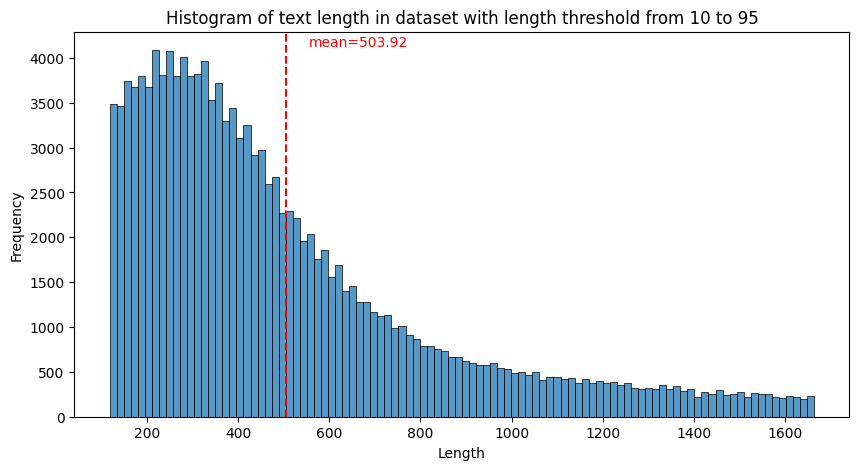

In [10]:
plot_histogram(
  df=df_10_95,
  column='text_length',
  title='Histogram of text length in dataset with length threshold from 10 to 95',
)

Saved to statistics/histogram_of_headline_length_in_dataset_with_length_threshold_from_10_to_95.png


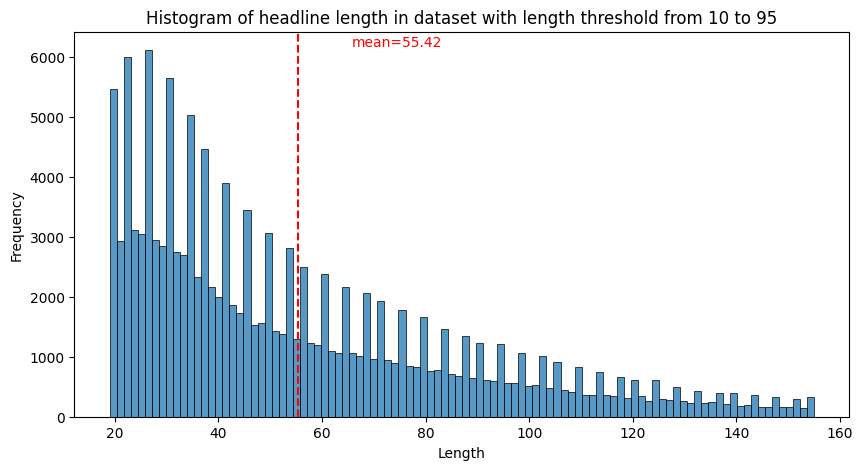

In [11]:
plot_histogram(
  df=df_10_95,
  column='headline_length',
  title='Histogram of headline length in dataset with length threshold from 10 to 95',
)

# Save filtered threshold data

In [12]:
df_normalized = df_10_95[['text', 'headline']]

print(f'Shape of dataset: {df_normalized.shape}')
print('Information of dataset:')
df_normalized.info()

df_normalized.to_csv('dataset/wikihow_normalized.csv')

Shape of dataset: (137598, 2)
Information of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137598 entries, 0 to 137597
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      137598 non-null  object
 1   headline  137598 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB
